R2 Score: 0.9600375984956886
MAE: 0.6351464480874307
RMSE: 0.959456761655438

Cross Validation R2 Mean: nan
Cross Validation R2 Std: nan
Cross Validation MAE Mean: nan


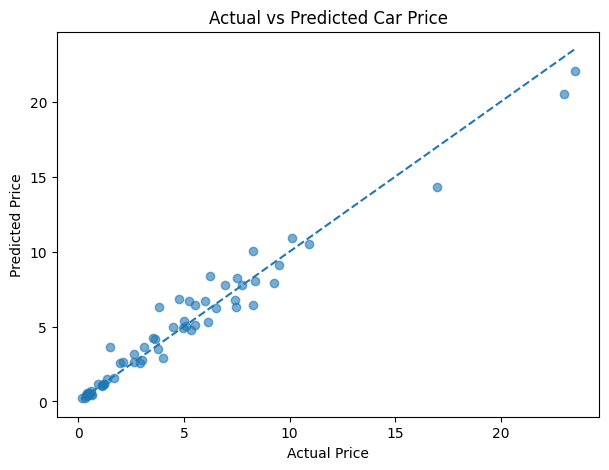

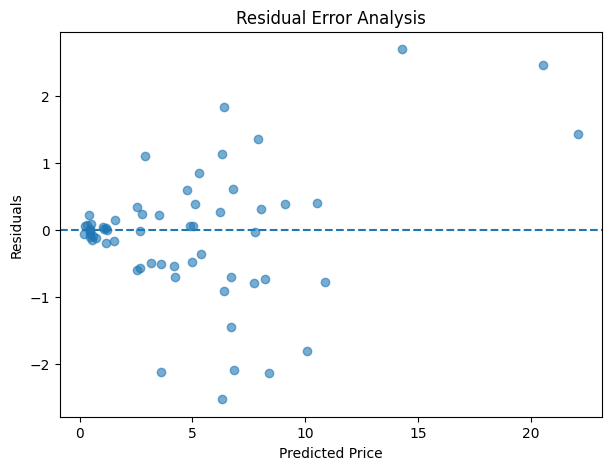

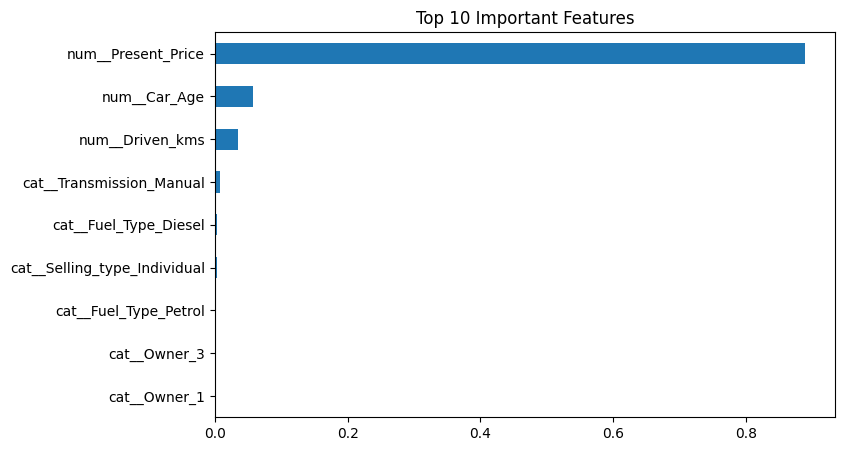

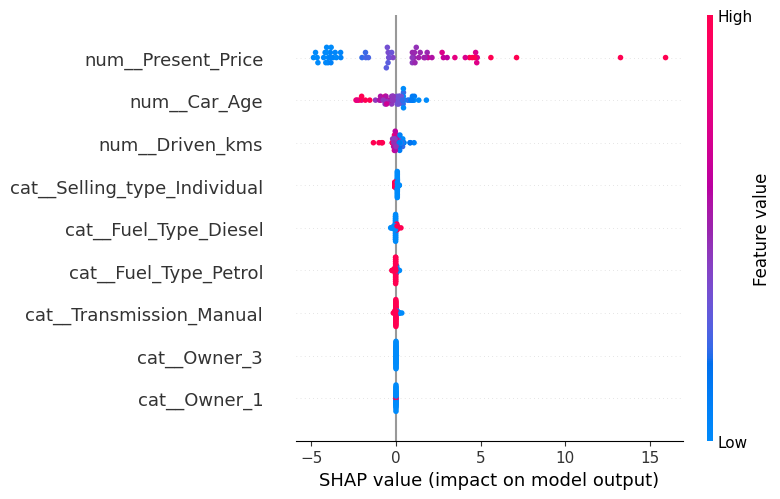


WITHOUT Present_Price
R2: 0.8238618284492117
MAE: 1.230288713244863


In [ ]:



# ---- 1. IMPORT LIBRARIES ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import shap
import warnings
warnings.filterwarnings("ignore")

# ---- 2. LOAD DATA ----
df = pd.read_excel("car data.xlsx")

# ---- 3. FEATURE ENGINEERING ----
df['Car_Age'] = 2025 - df['Year']
df.drop(columns=['Year', 'Car_Name'], inplace=True)

# ---- 4. DEFINE FEATURES & TARGET ----
X = df.drop('Selling_Price', axis=1)
y = df['Selling_Price']

categorical_features = ['Fuel_Type', 'Selling_type', 'Transmission', 'Owner']
numerical_features = ['Present_Price', 'Driven_kms', 'Car_Age']

# ---- 5. PREPROCESSING ----
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ]
)

# ---- 6. MODEL PIPELINE ----
model = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# ---- 7. TRAIN TEST SPLIT ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# ---- 8. EVALUATION METRICS ----
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R2 Score:", r2)
print("MAE:", mae)
print("RMSE:", rmse)

# ---- 9. CROSS VALIDATION ----
cv_r2 = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
cv_mae = -cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')

print("\nCross Validation R2 Mean:", cv_r2.mean())
print("Cross Validation R2 Std:", cv_r2.std())
print("Cross Validation MAE Mean:", cv_mae.mean())

# ---- 10. ACTUAL VS PREDICTED PLOT ----
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Price")
plt.show()

# ---- 11. RESIDUAL ANALYSIS ----
residuals = y_test - y_pred

plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residual Error Analysis")
plt.show()

# ---- 12. FEATURE IMPORTANCE ----
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = pipeline.named_steps['model'].feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,5))
feat_imp.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 10 Important Features")
plt.show()

# ---- 13. SHAP EXPLAINABILITY ----
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

explainer = shap.TreeExplainer(pipeline.named_steps['model'])
shap_values = explainer.shap_values(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

# ---- 14. MODEL WITHOUT PRESENT_PRICE (LEAKAGE CHECK) ----
X_no_price = X.drop(columns=['Present_Price'])

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_no_price, y, test_size=0.2, random_state=42
)

preprocessor2 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('num', 'passthrough', ['Driven_kms', 'Car_Age'])
    ]
)

pipeline2 = Pipeline(steps=[
    ('preprocessor', preprocessor2),
    ('model', RandomForestRegressor(n_estimators=300, random_state=42))
])

pipeline2.fit(X_train2, y_train2)
y_pred2 = pipeline2.predict(X_test2)

print("\nWITHOUT Present_Price")
print("R2:", r2_score(y_test2, y_pred2))
print("MAE:", mean_absolute_error(y_test2, y_pred2))

